In [7]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import product

import torch
import torch.nn as nn

In [ ]:
class GridWorld:
    def __init__(self, grid_size=5, wind=0.2):
        # (0,0) bottom left corner (x,y)
        self.names = ["Right", "Down", "Left", "Up"]
        self.actions = [(1,0),(0,1),(-1,0),(0,-1)]
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.wind = float(wind)
        
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size))

        self.features = np.eye(self.n_states)
        self.dynamics = self.transition_probabilities()
        self.real_rewards = np.array([self.reward(s) for s in range(self.n_states)])
        self.state = 0


    def reward(self, state_p):
        return 1 if state_p == self.n_states-1 else 0
        

    def reset(self):
        self.state = 0
        return self.state


    def step(self, a):
        probs = self.dynamics[:, a, self.state]
        self.state = np.random.choice(self.n_states, p=probs)
        return self.state


    def transition_probabilities(self):
        dynamics = np.zeros((self.n_states, self.n_actions, self.n_states))
        # S_t+1, A_t, S_t
        for s in range(self.n_states):
            x, y = s%self.grid_size, s//self.grid_size
            for a in range(self.n_actions):
                x_a, y_a = self.actions[a]
                for d in range(self.n_actions):
                    x_d, y_d = self.actions[d]
                    if 0 <= x+x_d < self.grid_size and 0 <= y+y_d < self.grid_size:
                        dynamics[(x+x_d) + (y+y_d)*self.grid_size, a, s] += self.wind/self.n_actions
                    else:
                        dynamics[s, a, s] += self.wind/self.n_actions
                if 0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size:
                    dynamics[(x+x_a) + (y+y_a)*self.grid_size, a, s] += 1 - self.wind
                else:
                    dynamics[s, a, s] += 1 - self.wind
                
        return dynamics

    
    def test(self):
        for s in range(self.n_states):
            print("/// State: ", s)
            for a in range(self.n_actions):
                print("/// Action: ", self.names[a])
                probs = self.dynamics[:, a, s]
                print(probs.reshape(-1, self.grid_size))


    def optimal_policy(self, state):
        x, y = state%self.grid_size, state//self.grid_size
        if x > y:
            return 1
        elif x < y:
            return 0
        else:
            return np.random.randint(2)


    def generate_trajectories(self, num, length, policy=None):
        if not policy:
            policy = self.optimal_policy

        trajs = []
        for n in range(num):
            t = []
            state = self.reset()
            for i in range(length):
                action = policy(state)
                state_p = self.step(action)
                t.append([state, action])
                state = state_p
            trajs.append(t)
        return np.array(trajs)

In [8]:
class WorldObject(object):
    def __init__(self, inner_color, outer_color):
        self.inner_color = inner_color
        self.outer_color = outer_color
        
class Objectworld:
    def __init__(self, grid_size, n_objects, n_colors, wind, discount):
        self.wind = float(wind)
        self.grid_size = grid_size
        self.actions = ((1, 0), (0, 1), (-1, 0), (0, -1), (0, 0))
        self.n_actions = len(self.actions)
        self.n_states = grid_size**2
        self.n_objects = n_objects
        self.n_colors = n_colors
        self.discount = discount

        self.objects = {}
        for _ in range(self.n_objects):
            obj = WorldObject(np.random.randint(self.n_colors), 
                              np.random.randint(self.n_colors))
            while True:
                x = np.random.randint(self.grid_size)
                y = np.random.randint(self.grid_size)

                if (x, y) not in self.objects:
                    break
            self.objects[x, y] = obj

        self.dynamics = self.transition_probabilities()
        self.real_rewards = np.array([self.reward(s) for s in range(self.n_states)])
            

    def feature_vector(self, state, discrete=True):
        x_s, y_s = state%self.grid_size, state//self.grid_size

        nearest_inner = {}
        nearest_outer = {}

        for y in range(self.grid_size):
            for x in range(self.grid_size):
                if (x, y) in self.objects:
                    dist = math.hypot((x - x_s), (y - y_s))
                    obj = self.objects[x, y]
                    if obj.inner_color in nearest_inner:
                        if dist < nearest_inner[obj.inner_color]:
                            nearest_inner[obj.inner_color] = dist
                    else:
                        nearest_inner[obj.inner_color] = dist
                    if obj.outer_color in nearest_outer:
                        if dist < nearest_outer[obj.outer_color]:
                            nearest_outer[obj.outer_color] = dist
                    else:
                        nearest_outer[obj.outer_color] = dist

        for c in range(self.n_colors):
            if c not in nearest_inner:
                nearest_inner[c] = 0
            if c not in nearest_outer:
                nearest_outer[c] = 0

        if discrete:
            state = np.zeros((2*self.n_colors*self.grid_size,))
            i = 0
            for c in range(self.n_colors):
                for d in range(1, self.grid_size+1):
                    if nearest_inner[c] < d:
                        state[i] = 1
                    i += 1
                    if nearest_outer[c] < d:
                        state[i] = 1
                    i += 1
        else:
            state = np.zeros((2*self.n_colors))
            i = 0
            for c in range(self.n_colors):
                state[i] = nearest_inner[c]
                i += 1
                state[i] = nearest_outer[c]
                i += 1

        return state


    def feature_matrix(self, discrete=True):
        return np.array([self.feature_vector(i, discrete)
                         for i in range(self.n_states)])


    def reward(self, state_p):
        x, y = state_p%self.grid_size, state_p//self.grid_size

        near_c0 = False
        near_c1 = False
        for (dx, dy) in product(range(-3, 4), range(-3, 4)):
            if 0 <= x + dx < self.grid_size and 0 <= y + dy < self.grid_size:
                if (abs(dx) + abs(dy) <= 3 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_color == 0):
                    near_c0 = True
                if (abs(dx) + abs(dy) <= 2 and
                        (x+dx, y+dy) in self.objects and
                        self.objects[x+dx, y+dy].outer_color == 1):
                    near_c1 = True
        if near_c0 and near_c1:
            return 1
        if near_c0:
            return -1
        return 0
        

    def reset(self, random=False):
        if random:
            self.state = np.random.randint(self.n_states)
        else:
            self.state = 0
        return self.state


    def step(self, a):
        probs = self.dynamics[:, a, self.state]
        self.state = np.random.choice(self.n_states, p=probs)
        return self.state


    def transition_probabilities(self):
        dynamics = np.zeros((self.n_states, self.n_actions, self.n_states))
        # S_t+1, A_t, S_t
        for s in range(self.n_states):
            x, y = s%self.grid_size, s//self.grid_size
            for a in range(self.n_actions):
                x_a, y_a = self.actions[a]
                for d in range(self.n_actions):
                    x_d, y_d = self.actions[d]
                    if 0 <= x+x_d < self.grid_size and 0 <= y+y_d < self.grid_size:
                        dynamics[(x+x_d) + (y+y_d)*self.grid_size, a, s] += self.wind/self.n_actions
                    else:
                        dynamics[s, a, s] += self.wind/self.n_actions
                if 0 <= x+x_a < self.grid_size and 0 <= y+y_a < self.grid_size:
                    dynamics[(x+x_a) + (y+y_a)*self.grid_size, a, s] += 1 - self.wind
                else:
                    dynamics[s, a, s] += 1 - self.wind
                
        return dynamics


    def optimal_policy(self):
        real_rewards = torch.tensor([self.reward(s) for s in range(self.n_states)], dtype=torch.float32)
        policy = value_iteration(0.0001, self, real_rewards, self.discount)
        return policy.argmax(1)


    def generate_trajectories(self, num, length, policy=None):
        if not policy:
            policy = self.optimal_policy()

        trajs = []
        for n in range(num):
            t = []
            state = self.reset(random=True)
            for i in range(length):
                action = policy[state]
                state_p = self.step(action)
                t.append([state, action, self.reward(state_p)])
                state = state_p
            trajs.append(t)
        return np.array(trajs)

In [9]:
def value_iteration(threshold, env, rewards, discount=0.01):
    transition = env.dynamics
    V = np.zeros(env.n_states)
    delta = np.inf

    while delta > threshold:
        delta = 0
        for s in range(env.n_states):
            max_v = -np.inf
            for a in range(env.n_actions):
                probs = env.dynamics[:, a, s]
                max_v = max(max_v, np.dot(probs, rewards + discount * V))
            delta = max(delta, abs(V[s] - max_v))
            V[s] = max_v

    policy = np.zeros((env.n_states, env.n_actions))
    for s in range(env.n_states):
        for a in range(env.n_actions):
            probs = env.dynamics[:, a, s]
            policy[s, a] = np.dot(probs, rewards + discount * V)

    policy = policy - policy.max(axis=1, keepdims=True)
    exps = np.exp(policy)
    policy = exps / exps.sum(axis=1, keepdims=True)
    return policy

In [14]:
class MaximumEntropy:
    def __init__(self, env, trajectories, features, lr=0.002, discount=0.9):
        self.env = env
        self.features = features
        self.trajectories = trajectories
        self.rews = []

        self.theta = np.random.uniform(size=(features.shape[1],))
        self.discount = discount
        self.lr = lr


    def get_rewards(self):
        return self.rews


    def expected_features(self):
        exp_f = np.zeros_like(self.features[0])
        for traj in self.trajectories:
            for s, *_ in traj:
                exp_f += self.features[s]
        return exp_f / self.trajectories.shape[0]


    def expected_state_visitation_frequency(self, policy):
        # probability of visiting the initial state
        prob_initial_state = np.zeros(self.env.n_states)
        for traj in self.trajectories:
            prob_initial_state[traj[0, 0]] += 1.0
        prob_initial_state = prob_initial_state / self.trajectories.shape[0]

        # Compute 𝜇
        mu = np.repeat([prob_initial_state], self.trajectories.shape[1], axis=0)
        for t in range(1, self.trajectories.shape[1]):
            mu[t, :] = 0
            for s in range(self.env.n_states):
                for a in range(self.env.n_actions):
                    for s_p in range(self.env.n_states):
                        mu[t, s] += mu[t-1, s_p] * policy[s_p, a] * self.env.dynamics[s_p, a, s]
        return mu.sum(axis=0)


    def train(self, n_epochs, save_rewards=True, plot=False):
        self.rews = []
        exp_f = self.expected_features()

        for i in tqdm(range(n_epochs)):
            rewards = self.features.dot(self.theta)
            if save_rewards:
                self.rews.append(rewards)
                
            policy = value_iteration(self.discount, self.env, rewards)
            exp_svf = self.expected_state_visitation_frequency(policy)

            grads = exp_f - exp_svf @ self.features
            self.theta += self.lr * grads

            if plot:
                plt.pcolor(rewards.reshape((self.env.grid_size, self.env.grid_size)))
                plt.colorbar()
                plt.show()

        return self.features.dot(self.theta)

In [15]:
grid_size = 5
random_rate = 0.3
num_trajectories = 50
len_trajectory = 30

n_epochs = 500
discount = 0.9
lr = 0.01

In [41]:
grid_size = 10
n_objects = 10
n_colors = 2
wind = 0.3
discount = 0.9

num_trajectories, len_trajectory = 300, 30
n_epochs = 500
lr = 0.001

In [17]:
ow = Objectworld(grid_size, n_objects, n_colors, wind, discount)
trajectories = ow.generate_trajectories(num_trajectories, len_trajectory)
features = ow.feature_matrix(discrete=True)

In [ ]:
gw = GridWorld(grid_size, random_rate)
trajectories = gw.generate_trajectories(num_trajectories, len_trajectory)
features = np.eye(gw.n_states)

In [ ]:
me = MaximumEntropy(ow, trajectories, features, lr, discount)
rewards = me.train(n_epochs, plot=True)

In [31]:
true_rewards = np.array([ow.reward(s) for s in range(grid_size*grid_size)]).reshape(grid_size, grid_size)

In [32]:
rewards = rewards.reshape(grid_size, grid_size)

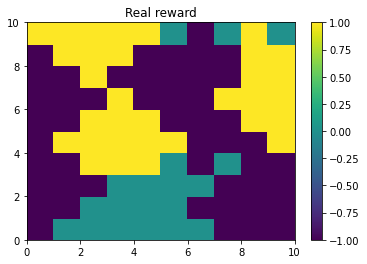

In [33]:
plt.pcolor(true_rewards)
plt.colorbar()
plt.title("Real reward")
plt.show()

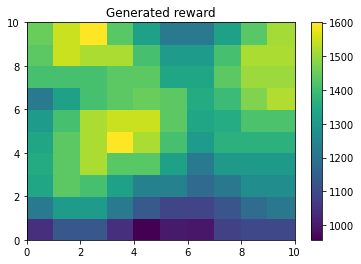

In [34]:
plt.pcolor(rewards)
plt.colorbar()
plt.title("Generated reward")
plt.show()

Record

In [35]:
from matplotlib.animation import FuncAnimation
from IPython import display

In [36]:
rews = me.get_rewards()

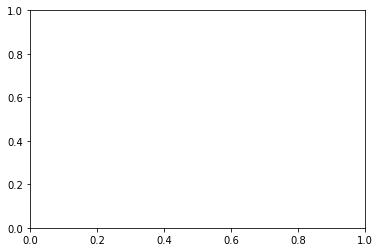

In [37]:
Figure = plt.figure()
ax = plt.subplot()

In [38]:
def AnimationFunction(frame):
    ax.pcolor(rews[frame].reshape(grid_size, grid_size))

In [39]:
anim_created = FuncAnimation(Figure, AnimationFunction, frames=len(rews), interval=25)

In [40]:
video = anim_created.to_html5_video()
html = display.HTML(video)
display.display(html)
 
# good practice to close the plt object.
plt.close()